# Data pre-process

### Imports and paths initialization

In [374]:
# imports for the whole notebook
from xml.etree import ElementTree as ET
import csv
import pandas as pd
import re
import numpy as np
import random
import os
import argparse
import rdflib
import matplotlib.pyplot as plt
# from gensim.models import KeyedVectors
import nltk
# from owl2vec_star import owl2vec_star


def parse_args(args=None):
    parser = argparse.ArgumentParser(
        description='Data pre-process',
        usage=''
    )
    parser.add_argument('--data_dir', type=str, default='data')
    parser.add_argument('--onto_dir', type=str, default='ontology')
    parser.add_argument('--syn_data_dir', type=str, default='syn_data')
    parser.add_argument('--onto_to_embed', type=str, default='hpObo_hoom_ordo.owl')
    parser.add_argument('--embedding_cfg_path', type=str, default='./embedding.cfg')

    return parser.parse_args(args)


# set the path to your data folders here
args = parse_args(args=['--data_dir', '../persistent/data'])
onto_dir_path = os.path.join(args.data_dir, args.onto_dir)
syn_data_dir_path = os.path.join(args.data_dir, args.syn_data_dir)

if not os.path.exists(onto_dir_path):
    raise ValueError(f'You need an existing ontology directory with the XML dataset inside it, please create \'{onto_dir_path}\'')

if not os.path.exists(syn_data_dir_path):
    os.makedirs(syn_data_dir_path)

### Convert XML dataset to CSV

In [31]:
# Dataset: clinical signs and symptoms in rare diseases
# http://www.orphadata.org/cgi-bin/index.php (Phenotypes associated with rare disorders)


tree = ET.parse(os.path.join(onto_dir_path, 'en_product4.xml'))
root = tree.getroot()


headers = ['HPODisorderSetStatus_id', 'Disorder_id', 'OrphaCode', 'ExpertLink',
           'Name', 'DisorderType_id', 'DisorderType_name', 'DisorderGroup_id',
           'DisorderGroup_Name', 'HPODisorderAssociation_id', 'HPO_id',
           'HPOId', 'HPOTerm', 'HPOFrequency_id', 'HPOFrequency_Name',
           'DiagnosticCriteria_id', 'DiagnosticCriteria_Name', 'Source',
           'ValidationStatus', 'Online', 'ValidationDate']


def find_value(row_data, source_tag, target_tag_name, field, text=True):
    """Finds a sub-tag of a source tag and inputs its value into a dictionary
        containing the current row's data

    Args:
        row_data (dict):
            The data for the current row associated with the csv fields
        source_tag (Element):
            XML parent tag to search from
        target_tag_name (str):
            Name of the sub-tag to find
        field (str):
            Field in the csv file
        text (bool):
            Indicates if the value of the tag to retrieve is its inner text 
            or its id attribute
    Returns:
        tag (Element):
            Returns the found tag
    """
    tag = source_tag.find(target_tag_name)
    tag_v = ''

    if tag is not None:  # retrieving either the inner text or the id attribute of the tag
        if text:
            tag_v = tag.text
        elif (len(tag.attrib) > 0):
            tag_v = tag.attrib['id']
    row_data[field] = tag_v if tag_v is not None else ''

    return tag


with open(os.path.join(onto_dir_path, 'en_product4.csv'), 'w', encoding='utf-8') as fd:
    csvwriter = csv.DictWriter(fd, delimiter=',', fieldnames=headers)
    csvwriter.writeheader()

    # iterating through all the disorders
    for status in root.find('HPODisorderSetStatusList').findall('HPODisorderSetStatus'):
        row_data = {}
        row_data['HPODisorderSetStatus_id'] = status.attrib['id']

        disorder_tag = find_value(row_data, status, 'Disorder', 'Disorder_id', text=False)
        find_value(row_data, disorder_tag, 'OrphaCode', 'OrphaCode', text=True)
        find_value(row_data, disorder_tag, 'ExpertLink', 'ExpertLink', text=True)
        find_value(row_data, disorder_tag, 'Name', 'Name', text=True)

        disordertype_tag = find_value(row_data, disorder_tag, 'DisorderType', 'DisorderType_id', text=False)
        find_value(row_data, disordertype_tag, 'Name', 'DisorderType_name', text=True)
        disordergroup_tag = find_value(row_data, disorder_tag, 'DisorderGroup', 'DisorderGroup_id', text=False)
        find_value(row_data, disordergroup_tag, 'Name', 'DisorderGroup_Name', text=True)

        for field in ['Source', 'ValidationStatus', 'Online', 'ValidationDate']:
            find_value(row_data, status, field, field, text=True)

        # iterating through all the disorder associations and writing a row for each association
        for association in disorder_tag.find('HPODisorderAssociationList').findall('HPODisorderAssociation'):
            row_data['HPODisorderAssociation_id'] = association.attrib['id']

            hpo_tag = find_value(row_data, association, 'HPO', 'HPO_id', text=False)
            find_value(row_data, hpo_tag, 'HPOId', 'HPOId', text=True)
            find_value(row_data, hpo_tag, 'HPOTerm', 'HPOTerm', text=True)
            hpofrequency_tag = find_value(row_data, association, 'HPOFrequency', 'HPOFrequency_id', text=False)
            find_value(row_data, hpofrequency_tag, 'Name', 'HPOFrequency_Name', text=True)

            diagnosticcriteria_tag = find_value(row_data, association, 'DiagnosticCriteria', 'DiagnosticCriteria_id', text=False)
            find_value(row_data, diagnosticcriteria_tag, 'Name', 'DiagnosticCriteria_Name', text=True)

            csvwriter.writerow(row_data)

In [32]:
df = pd.read_csv(os.path.join(onto_dir_path, 'en_product4.csv'))
df.head(5)

,HPODisorderSetStatus_id,Disorder_id,OrphaCode,ExpertLink,Name,DisorderType_id,DisorderType_name,DisorderGroup_id,DisorderGroup_Name,HPODisorderAssociation_id,...,HPOId,HPOTerm,HPOFrequency_id,HPOFrequency_Name,DiagnosticCriteria_id,DiagnosticCriteria_Name,Source,ValidationStatus,Online,ValidationDate
0,1,2,58,http://www.orpha.net/consor/cgi-bin/OC_Exp.php...,Alexander disease,21394,Disease,36547,Disorder,327485,...,HP:0000256,Macrocephaly,28412,Very frequent (99-80%),NaN,NaN,NaN,y,y,2016-06-01 00:00:00.0
1,1,2,58,http://www.orpha.net/consor/cgi-bin/OC_Exp.php...,Alexander disease,21394,Disease,36547,Disorder,327486,...,HP:0001249,Intellectual disability,28412,Very frequent (99-80%),NaN,NaN,NaN,y,y,2016-06-01 00:00:00.0
2,1,2,58,http://www.orpha.net/consor/cgi-bin/OC_Exp.php...,Alexander disease,21394,Disease,36547,Disorder,327487,...,HP:0001250,Seizures,28412,Very frequent (99-80%),NaN,NaN,NaN,y,y,2016-06-01 00:00:00.0
3,1,2,58,http://www.orpha.net/consor/cgi-bin/OC_Exp.php...,Alexander disease,21394,Disease,36547,Disorder,327488,...,HP:0001257,Spasticity,28412,Very frequent (99-80%),NaN,NaN,NaN,y,y,2016-06-01 00:00:00.0
4,1,2,58,http://www.orpha.net/consor/cgi-bin/OC_Exp.php...,Alexander disease,21394,Disease,36547,Disorder,327489,...,HP:0001274,Agenesis of corpus callosum,28412,Very frequent (99-80%),NaN,NaN,NaN,y,y,2016-06-01 00:00:00.0


### Dataset to triples, entities and relations

In [33]:
freq_assoc = {  # from csv frequency to frequency code
    'Obligate (100%)': 'O',
    'Very frequent (99-80%)': 'VF',
    'Frequent (79-30%)': 'F',
    'Occasional (29-5%)': 'OC',
    'Very rare (<4-1%)': 'VR',
    'Excluded (0%)': 'E'
}

freq_code_assoc = {  # from frequency code to output class
    'O': 'obligate',
    'VF': 'very_frequent',
    'F': 'frequent',
    'OC': 'occasional',
    'VR': 'very_rare',
    'E': 'excluded'
}

dc_association = {  # default: exclusion
    'Diagnostic criterion': 'diagnostic_criterion',
    'Pathognomonic sign': 'pathognomonic_sign',
}


def get_association_subclass(orpha, freq, hp):
    """Returns normalized association class

    Args:
        orpha (str):
            The prefixed Orphanet code
        freq (str):
            The frequency text
        hp (str):
            The prefixed HPO ID
    Returns:
        (str):
            The orphacode, hpo id and frequency association
    """
    return orpha + '_' + hp + '_FREQ:' + freq_assoc.get(freq)


def get_association_name(orpha, freq, hp):
    """Returns textual description of the association class

    Args:
        orpha (str):
            The prefixed Orphanet code
        freq (str):
            The frequency text
        hp (str):
            The prefixed HPO ID
    Returns:
        (str):
            The orphacode, hpo id and frequency association 
            textual_description_with_underscores
    """
    return get_normalized_string(orpha_entities.get(orpha) + ' and ' +
                                 hpo_entities.get(hp) + ' ' +
                                 freq_code_assoc.get(freq_assoc.get(freq)) +
                                 ' association')


def get_normalized_string(s):
    """Transforms a string to lowercase and replaces all whitespace runs with an underscore

    Args:
        s (str):
            String to normalize
    Returns:
        (str):
            The normalized string
    """
    return re.sub(r"\s+", '_', s.lower())


df_dataset = pd.read_csv(os.path.join(onto_dir_path, 'en_product4.csv'), 
                         dtype='object')
df_dataset['OrphaCode'] = df_dataset['OrphaCode'].map(lambda x: 'ORPHA:' + x)

# key is id, value is textual_description_with_underscores
assoc_entities = {}
dc_entities = {'diagnostic_criterion': 'diagnostic_criterion',
               'pathognomonic_sign': 'pathognomonic_sign',
               'exclusion': 'exclusion'}
freq_assoc_entities = {'obligate': 'obligate', 'very_frequent': 'very_frequent',
                       'frequent': 'frequent', 'occasional': 'occasional',
                       'very_rare': 'very_rare', 'excluded': 'excluded'}
hpo_entities = {}
orpha_entities = {}

has_object_triples = []  # association has_object HPOId
has_subject_triples = []  # association has_subject OrphaCode
has_frequency_triples = []  # association has_frequency FrequencyAssociation
has_diagnostic_criterion_triples = []  # association has_DC_attribute DC


# reading the dataset
for orpha, freq, hp, dc, \
    orpha_name, hpo_name in zip(df_dataset['OrphaCode'],
                                df_dataset['HPOFrequency_Name'],
                                df_dataset['HPOId'],
                                df_dataset['DiagnosticCriteria_Name'],
                                df_dataset['Name'],
                                df_dataset['HPOTerm']):
    if hp not in hpo_entities:
        hpo_entities[hp] = get_normalized_string(hpo_name)
    if orpha not in orpha_entities:
        orpha_entities[orpha] = get_normalized_string(orpha_name)

    ac = get_association_subclass(orpha, freq, hp)
    ac_name = get_association_name(orpha, freq, hp)
    assoc_entities[ac] = ac_name

    has_object_triples.append((ac, 'association_has_object', hp))
    has_subject_triples.append((ac, 'association_has_subject', orpha))
    has_frequency_triples.append((ac, 'has_frequency', freq_code_assoc.get(freq_assoc.get(freq))))
    has_diagnostic_criterion_triples.append((ac, 'has_DC_attribute', dc_association.get(dc, 'exclusion')))


# lists corresponding to each output file
triples = []
triples_names = []
entities = []
entities_names = []
relations = []

# subClassOf triples
entities_and_parent_class = [
    (assoc_entities, 'association'),
    (dc_entities, 'diagnostic_criteria'), 
    (freq_assoc_entities, 'frequency_association'), 
    (hpo_entities, 'HPO_Id'), 
    (orpha_entities, 'OrphaCode')
]
for (entities_dict, parent_class) in entities_and_parent_class:
    for k, v in entities_dict.items(): 
        triples.append((k, 'subClassOf', get_normalized_string(parent_class)))
        triples_names.append((v, 'subClassOf', parent_class))

# other properties triples
triples_and_entities = [
    (has_object_triples, hpo_entities), 
    (has_subject_triples, orpha_entities), 
    (has_frequency_triples, freq_assoc_entities), 
    (has_diagnostic_criterion_triples, dc_entities)
]
for (properties_triples, entities_dict) in triples_and_entities:
    for (s, r, o) in properties_triples:
        triples.append((s, r, o))
        triples_names.append((assoc_entities.get(s), r, entities_dict.get(o)))

# parent entities
for i, (k, v) in enumerate(entities_and_parent_class):
    parent = get_normalized_string(v)
    entities.append((i, parent))
    entities_names.append((i, parent))
# entities
parents_count = len(entities)
for i, (k, v) in enumerate({**assoc_entities, **dc_entities, **freq_assoc_entities,
                            **hpo_entities, **orpha_entities}.items()):
    entities.append((i+parents_count, k))
    entities_names.append((i+parents_count, v))

# relations
for i, r in enumerate(['subClassOf', 'association_has_object',
                       'association_has_subject', 'has_frequency', 
                       'has_DC_attribute']):
    relations.append((i, r))


# writing to the different files
lists_and_files = [
    (triples, 'triples.txt'), 
    (triples_names, 'triples_names.txt'),
    (entities, 'entities.dict'),
    (entities_names, 'entities_names.dict'),
    (relations, 'relations.dict')
]
for (l, n) in lists_and_files:
    with open(os.path.join(onto_dir_path, n), 'w') as f:
        for t in l:
            f.write('\t'.join(str(e) for e in t) + '\n')

### Merge ORDO, HP and HOOM ontologies using Protégé

https://bioportal.bioontology.org/ontologies/ORDO?p=summary 
    
https://bioportal.bioontology.org/ontologies/HP?p=summary 

https://bioportal.bioontology.org/ontologies/HOOM?p=summary
'HOOM is a module that qualifies the annotation between a clinical entity and phenotypic abnormalities according to a frequency and by integrating the notion of diagnostic criterion.'

Using Protégé, merge HP (in OBO format, very important) into HOOM (OWL) and then ORDO (OWL) into the result of the merge, to obtain a merge of the 3 ontologies, export in OWL/XML format, and export in turtle format too

### Seen and unseen RDs from the ontology

#### Loading the ontology graph

In [102]:
g = rdflib.Graph()
g.parse('../persistent/data/ontology/hpObo_hoom_ordo.ttl')

print(f'len g: {len(g)}')

len g: 4162248


#### Get all RDs and their corresponding groups

In [282]:
# iri of group of disorders class <http://www.orpha.net/ORDO/Orphanet_557492>
# part of <http://www.orpha.net/ORDO/Orphanet_C021>
# Rare hereditary metabolic disease with peripheral neuropathy <http://www.orpha.net/ORDO/Orphanet_207018>
# Subtype of disorder <http://www.orpha.net/ORDO/Orphanet_557494>

groups_query = """
SELECT ?rd_g ?rd
WHERE {
    ?rd_uri rdf:type owl:Class;
            <http://www.orpha.net/ORDO/Orphanet_C021> ?rd_g .
    BIND (STR(?rd_uri) AS ?rd) .
}
"""

groups_qres = g.query(groups_query)

#### Get RDs seen in Association classes

In [279]:
rds_query = """
SELECT DISTINCT ?rd
{
    ?subject rdfs:subClassOf :Association .
    BIND(REPLACE(STR(?subject), ".*Orpha:([0-9]+).*", "$1") AS ?sub) .
    BIND(CONCAT("http://www.orpha.net/ORDO/Orphanet_", ?sub) AS ?rd) .
}
"""

rds_qres = g.query(rds_query)

#### Building a dictionary of RD groups and their RDs seen in Association classes

In [285]:
rd_list = []
rd_groups_dict = {}

# set of all RDs
for row in rds_qres:
    rd_list.append(str(row.rd))
rd_set = set(rd_list)

# RD groups dictionary
for row in groups_qres:
    rd = str(row.rd)
    rd_g = str(row.rd_g)
    if rd in rd_set:
        if rd_g not in rd_groups_dict:
            rd_groups_dict[rd_g] = []
        if rd not in rd_groups_dict[rd_g]:
            rd_groups_dict[rd_g].append(rd)

print(f'Number of unique, seen in Association classes RDs: {len(rd_list)} {len(rd_set)}\nNumber of RD groups: {len(rd_groups_dict)}')

len_sum = sum(len(dct) for dct in rd_groups_dict.values())

print(f'Total number of RDs in groups: {len_sum}\nAverage: {len_sum/len(rd_groups_dict)}')

Number of unique, seen in Association classes RDs: 4345 4345
Number of RD groups: 1692
Total number of RDs in groups: 10484
Average: 6.196217494089835
test list: 10484 4196
Number of seen RDs: 3775 (86.88%)
Number of unseen RDs: 570 (13.12%)


#### Building sets of seen and unseen RDs

In [368]:
# seen and unseen RDs sets
seen_rds = set()
unseen_rds = set()


def populating_rd_sets(method='no_groups', shuffle=False, unseen_pct=0.2, selected_rds=[]):
    """Builds sets of seen and unseen RDs for synthetic data generation.
       The populated sets are global variables outside this function. 

    Args:
        method (str):
            Method to choose to build the sets, one of 'no_groups', 'parts_groups', 'whole_groups', 'selected_rds':
            'no_groups' adds a guaranteed percentage (unseen_pct) of all RDs to unseen RDs, regardless of their groups.
            'parts_groups' adds a percentage (unseen_pct) of RDs inside groups to unseen RDs, 
                eventually stopping if unseen_rds exceeds the unseen_pct of the RDs total.
            'whole_groups' adds all RDs of each group to unseen RDs until unseen_rds exceeds the unseen_pct of the RDs total.
            'selected_rds' only adds the selected rds to unseen RDs.
            Defaults to 'no_groups'.
        shuffle (bool)
            Whether to shuffle the order of the rd groups dictionary. Defaults to False.
        rds_pct (float):
            The wished ratio of unseen RDs. Defaults to 0.2.
        selected_rds (list-like):
            The list-like object of the IRIs of unseen RDs, only used if the method is 'selected_rds'.
    """
    methods = {'no_groups', 'parts_groups', 'whole_groups', 'selected_rds'}
    if method not in methods:
        raise Exception(f'Unknown method "{method}", should be one of {methods}')

    total_rds = len(rd_set)

    # building the sets
    if method == 'no_groups':
        indexes = [i for i in range(len(rd_list))]
        if shuffle:
            random.shuffle(indexes)
        for ind in indexes:  # iterating on all RDs
            rd = rd_list[ind]
            if (rd not in seen_rds) and (rd not in unseen_rds):
                if len(unseen_rds) > total_rds*unseen_pct:
                    seen_rds.add(rd)
                else:
                    unseen_rds.add(rd)

    elif method == 'parts_groups':
        keys = list(rd_groups_dict.keys())
        if shuffle:
            random.shuffle(keys)
        for rd_group in keys:  # iterating on groups
            rds = rd_groups_dict[rd_group]
            # counting unseen RDs to stop at rds*pct threshold
            unseen_cnt = 0
            if len(unseen_rds) > total_rds*unseen_pct:
                # no more RDs added to unseen RDs if unseen_rds is over the threshold
                unseen_cnt = len(unseen_rds)
            for rd in rds:
                if rd in unseen_rds:
                    unseen_cnt += 1
                else:
                    if rd not in seen_rds:
                        if unseen_cnt > len(rds)*unseen_pct:
                            seen_rds.add(rd)
                        else:
                            unseen_rds.add(rd)
                            unseen_cnt += 1

    elif method == 'whole_groups':  # pct of unseen RDs not guaranteed
        keys = list(rd_groups_dict.keys())
        if shuffle:
            random.shuffle(keys)
        for rd_group in keys:  # iterating on groups
            rds = rd_groups_dict[rd_group]
            if len(unseen_rds) > total_rds*unseen_pct:
                for rd in rds:
                    if (rd not in seen_rds) and (rd not in unseen_rds):
                        seen_rds.add(rd)
            else:
                for rd in rds:
                    if rd not in unseen_rds:
                        unseen_rds.add(rd)

    elif method == 'selected_rds':
        for rd in selected_rds:  # iterating on chosen groups
            if rd in rd_set:
                if rd not in unseen_rds:
                    unseen_rds.add(rd)
            else:
                raise Exception(f'Unknown RD {rd}')
        # adding the non chosen RDs to seen_rds
        for rds in rd_groups_dict.values():
            for rd in rds:
                if (rd not in seen_rds) and (rd not in unseen_rds):
                    seen_rds.add(rd)

    if method != 'no_groups':
        # TODO: allow some of these to be added to unseen_rds?
        # adding the RDs that aren't part of a RD group, in the seen set
        for rd in rd_list:
            if (rd not in seen_rds) and (rd not in unseen_rds):
                seen_rds.add(rd)


# populating_rd_sets(method='parts_groups', shuffle=False, unseen_pct=0.20)
picked = [
    "http://www.orpha.net/ORDO/Orphanet_517",  # Acute myelomonocytic leukemia
    "http://www.orpha.net/ORDO/Orphanet_90068",  # Cocaine intoxication
    "http://www.orpha.net/ORDO/Orphanet_420741"  # RIDDLE syndrome
]
populating_rd_sets(method='selected_rds', selected_rds=picked)

print(f'Number of seen RDs: {len(seen_rds)} ({(len(seen_rds)/len(rd_set)*100):.2f}%)\nNumber of unseen RDs: {len(unseen_rds)} ({(len(unseen_rds)/len(rd_set)*100):.2f}%)')

Number of seen RDs: 4342 (99.93%)
Number of unseen RDs: 3 (0.07%)


### Synthetic data generation from the ontology

In [432]:
frequency_dict = {  # frequency ids + associated probability
    28405: 1,  # Obligate (100%)
    28412: 0.895,  # Very frequent (99-80%)
    28419: 0.545,  # Frequent (79-30%)
    28426: 0.17,  # Occasional (29-5%)
    28433: 0.025,  # Very rare (<4-1%)
    28440: 0  # Excluded (0%)
}


def get_orpha_iri(orphacode):
    return f'http://www.orpha.net/ORDO/Orphanet_{orphacode}'


def gen_syn_data(patients_per_rd=10, gen_small_file=False, print_every=0, del_col_th=0, selected_rds=[]):
    """Generates synthetic seen and unseen data from the ontology into files

    Args:
        patients_per_rd (int):
            Number of generated patients per RD. Defaults to 10.
        gen_small_file (bool):
            Whether to generate very small files to debug the model or the full ones.
            Defaults to False.
        print_every (int):
            Each number of patients to print progress during data generation (0 = no print).
            Defaults to 0.
        selected_rds (list-like):
            Hand-picked list of RD names to use for generation.
        del_col_th (int):
            How few values for a column to be deleted (inclusive), 0 for no deletion. Defaults to 0.
    """
    df = pd.read_csv(os.path.join(onto_dir_path, 'en_product4.csv'))

    if len(selected_rds) > 0:
        df = df.loc[df['Name'].isin(selected_rds)]
    elif gen_small_file:
        grouped = df.groupby('Name', sort=False)
        df = pd.concat([group for name, group in grouped][:10])
    grouped = df.groupby('Name', sort=False)

    rd_count = grouped.ngroups
    unique_hps = df.HPOTerm.unique()
    total_hp_count = len(unique_hps)

    print(f'{rd_count} unique rare diseases, {total_hp_count} unique phenotypes')

    phenotypes = unique_hps.tolist()
    phenotypes_dict = {hp: i for i, hp in enumerate(phenotypes)}

    seen_patients_data = [['rare_disease'] + phenotypes]
    unseen_patients_data = [['rare_disease'] + phenotypes]

    distribution_check = {  # value: count of patients with hp + maximum count of patients that could've had the hp
        28405: [0, 0],  # Obligate (100%)
        28412: [0, 0],  # Very frequent (99-80%)
        28419: [0, 0],  # Frequent (79-30%)
        28426: [0, 0],  # Occasional (29-5%)
        28433: [0, 0],  # Very rare (<4-1%)
        28440: [0, 0]  # Excluded (0%)
    }

    patients_count = 0

    for group_nb, (name, group) in enumerate(grouped):  # for each RD
        hp_count = len(group)
        # generate patients_per_rd patients for each RD
        for patient in range(patients_count, patients_count+patients_per_rd):
            temp_hp = []
            proba_results = np.random.rand(hp_count)  # generating random floats for probabilities
            rd_n = ''
            rd_iri = ''
            for i, (orphacode, rd_name, hp_name, frequency_id) in enumerate(zip(
                                                            group['OrphaCode'],
                                                            group['Name'],
                                                            group['HPOTerm'],
                                                            group['HPOFrequency_id'])):
                distribution_check.get(frequency_id)[1] += 1
                if rd_n == '':
                    rd_n = rd_name
                    rd_iri = get_orpha_iri(orphacode)
                if (proba_results[i] >= 1 - frequency_dict[frequency_id]):  # comparing generated float and proba
                    temp_hp.append(hp_name)
                    distribution_check.get(frequency_id)[0] += 1

            if len(temp_hp) > 0:
                row = np.zeros((total_hp_count,), dtype=int)
                for hp in temp_hp:
                    row[phenotypes_dict.get(hp)] = 1
                if rd_iri in seen_rds:
                    seen_patients_data.append(np.concatenate([[rd_n], row]))
                elif rd_iri in unseen_rds:
                    unseen_patients_data.append(np.concatenate([[rd_n], row]))
                else:
                    print(f'Unknown RD {rd_n}')
                    continue  # skipping unknown RD
                if print_every > 0:
                    if patients_count % print_every == 0:
                        print(f'{patients_count}/{patients_per_rd*rd_count} patients generated')

                patients_count += 1

    if del_col_th > 0:
        seen_col_sum = np.sum(np.array(seen_patients_data)[1:, 1:].astype(int), axis=0)
        unseen_col_sum = np.sum(np.array(unseen_patients_data)[1:, 1:].astype(int), axis=0)
        seen_mask = [True] + [s >= del_col_th for s in seen_col_sum]
        unseen_mask = [True] + [s >= del_col_th for s in unseen_col_sum]
        seen_patients_data = np.transpose(np.transpose(seen_patients_data)[seen_mask])
        unseen_patients_data = np.transpose(np.transpose(unseen_patients_data)[unseen_mask])
        seen_patients_data = pd.DataFrame(seen_patients_data[1:], columns=seen_patients_data[0])
        unseen_patients_data = pd.DataFrame(unseen_patients_data[1:], columns=unseen_patients_data[0])
    else:
        # remove columns with only zeros
        seen_patients_data = pd.DataFrame(seen_patients_data[1:], columns=seen_patients_data[0])
        seen_patients_data = seen_patients_data.loc[:, (seen_patients_data != '0').any(axis=0)]
        unseen_patients_data = pd.DataFrame(unseen_patients_data[1:], columns=unseen_patients_data[0])
        unseen_patients_data = unseen_patients_data.loc[:, (unseen_patients_data != '0').any(axis=0)]

    print(f'{len(seen_patients_data)} seen patients generated ({len(seen_patients_data.columns)} columns), {len(unseen_patients_data)} unseen patients generated ({len(unseen_patients_data.columns)} columns), writing to files')

    # writing the 2 files
    seen_patients_data.to_csv(
        os.path.join(syn_data_dir_path, ('small_' if gen_small_file else '') + 'syn_patients_data_seen.csv'),
        encoding='utf-8', index=False, header=True
    )
    unseen_patients_data.to_csv(
        os.path.join(syn_data_dir_path, ('small_' if gen_small_file else '') + 'syn_patients_data_unseen.csv'),
        encoding='utf-8', index=False, header=True
    )

    print(f'Total RDs: {rd_count}, seen RDs: {int(len(seen_patients_data)/patients_per_rd)}, unseen RDs: {int(len(unseen_patients_data)/patients_per_rd)}')

    return distribution_check


rds = [
    "Acute myelomonocytic leukemia",
    "Deafness-lymphedema-leukemia syndrome",
    "Acute promyelocytic leukemia",
    "Chronic myeloid leukemia",
    "Acute monoblastic/monocytic leukemia",
    "Acute erythroid leukemia",
    "Unclassified myelodysplastic syndrome",
    "Adrenomyeloneuropathy",
    "Primary myelofibrosis",
    "Multiple myeloma",
    "Acute panmyelosis with myelofibrosis",
    "Alpha-thalassemia-myelodysplastic syndrome"
]
distributions = gen_syn_data(patients_per_rd=10, gen_small_file=False, print_every=1000, del_col_th=10, selected_rds=rds)

12 unique rare diseases, 179 unique phenotypes
0/120 patients generated
110 seen patients generated (30 columns), 10 unseen patients generated (2 columns), writing to files
Total RDs: 12, seen RDs: 11, unseen RDs: 1


[(28405, [6100, 6100]), (28412, [231503, 258920]), (28419, [204675, 374800]), (28426, [69615, 411400]), (28433, [1631, 64140]), (28440, [0, 7050])]


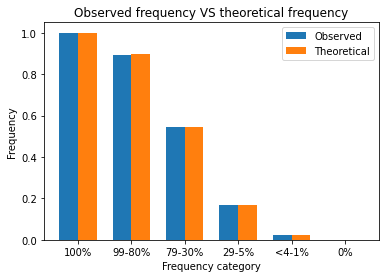

In [42]:
def show_distributions(frequency_obs, frequency_th):

    index = np.arange(len(frequency_obs))
    bar_width = 0.35

    fix, ax = plt.subplots()

    ax.bar(index, frequency_obs, bar_width, label='Observed')
    ax.bar(index+bar_width, frequency_th, bar_width, label='Theoretical')

    ax.set_xlabel('Frequency category')
    ax.set_ylabel('Frequency')
    ax.set_title('Observed frequency VS theoretical frequency')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(['100%', '99-80%', '79-30%', '29-5%', '<4-1%', '0%'])
    ax.legend()

    plt.show()


sorted_items = sorted(distributions.items(), key=lambda x: x[0])
print(sorted_items)
frequency_obs = [t[1][0]/t[1][1] if t[1][0] != 0 else t[1][0] for t in sorted_items]
sorted_freq = sorted(frequency_dict.items(), key=lambda x: x[0])
frequency_th = [x[1] for x in sorted_freq]
show_distributions(frequency_obs, frequency_th)

### ORDO and HPO URIs dictionaries

In [336]:
# normalized names to ORDO URIs and HPO URIs

df = pd.read_csv(os.path.join(onto_dir_path, 'en_product4.csv'))

df_hp = df[['HPOTerm', 'HPOId']].drop_duplicates()
df_rd = df[['Name', 'OrphaCode']].drop_duplicates()
df_hp['HPOId'] = 'http://purl.obolibrary.org/obo/' + df_hp['HPOId'].str.replace(':', '_')
df_rd['OrphaCode'] = 'http://www.orpha.net/ORDO/Orphanet_' + df_rd['OrphaCode'].astype(str)

df_hp.to_csv(os.path.join(onto_dir_path, 'HPO.dict'), sep=';', encoding='utf-8', index=False, header=False)
df_rd.to_csv(os.path.join(onto_dir_path, 'ORDO.dict'), sep=';', encoding='utf-8', index=False, header=False)

NameError: name 'pd' is not defined

### Embedding the ontology with Owl2Vec*

In [44]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
output_folder = '../persistent/data/ontology/embeddings/hpObo_hoom_ordo'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

"""
Parameters:
    ontology_file
    config_file
    uri_doc
    lit_doc
    mix_doc
    -> modify the cfg file for more params (cache dir, epochs, etc.)
"""
gensim_model = owl2vec_star.extract_owl2vec_model(None, "./embedding.cfg", True, True, True)

# Gensim format
gensim_model.save(os.path.join(output_folder, 'ontology.embeddings'))

# Text format (not required)
gensim_model.wv.save_word2vec_format(os.path.join(output_folder, "ontology.embeddings.txt"), binary=False)

Traceback (most recent call last):
  File "OWL2Vec-Star/OWL2Vec_Standalone.py", line 6, in <module>
    import gensim
ModuleNotFoundError: No module named 'gensim'


In [ ]:
#Embedding vectors generated above
model = KeyedVectors.load(output_folder+"ontology.embeddings", mmap='r')
wv = model.wv

word = 'http://www.orpha.net/ORDO/Orphanet_556985'
vector = wv[word]  # Get numpy vector of a word
print(f"Vector for {word}: {vector}")

#Most similar cosine similarity
result1 = wv.most_similar(positive=[word])
print(result1)

#Most similar entities: cosmul
result2 = wv.most_similar_cosmul(positive=[word])
print(result2)